In [33]:
import talib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import pyplot
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import ParameterGrid
from sklearn import metrics
from sklearn.linear_model import LinearRegression
%matplotlib inline

stock_data = pd.read_csv('Uniqlo.csv')

In [34]:
stock_data = stock_data.rename(columns={'Stock Trading': 'Trading Value'})
stock_data = stock_data.iloc[::-1].reset_index(drop=True)
stock_data.dropna(inplace = True)
stock_data.set_index('Date', inplace=True)

In [35]:
stock_data.head()

,Open,High,Low,Close,Volume,Trading Value
Date,,,,,,
2012-01-04,14050,14050,13700,13720,559100,7719804000
2012-01-05,13720,13840,13600,13800,511500,7030811000
2012-01-06,13990,14030,13790,13850,765500,10635609000
2012-01-10,13890,14390,13860,14390,952300,13533413000
2012-01-11,14360,14750,14280,14590,1043400,15191988000


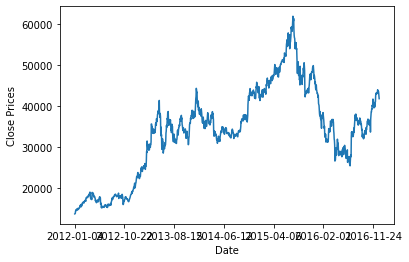

In [36]:
stock_data['Close'].plot()
plt.ylabel("Close Prices")
plt.show()

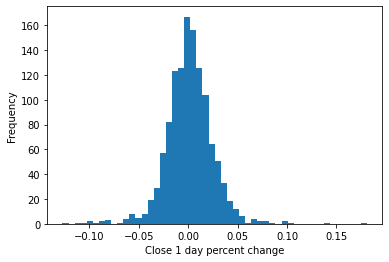

In [37]:
stock_data['Close'].pct_change().plot.hist(bins=50)
plt.xlabel("Close 1 day percent change")
plt.show()

In [38]:
stock_data['Close'] = stock_data['Close'].astype('float64')

In [39]:
feature_names = ['Open', 'High', 'Low', 'Close', 'Volume']
for n in [14, 30, 50, 200]:
    stock_data['ma' + str(n)] = talib.SMA(stock_data['Close'].values, timeperiod=n)
    stock_data['rsi' + str(n)] = talib.RSI(stock_data['Close'].values, timeperiod=n)

    feature_names = feature_names + ['ma' + str(n), 'rsi' + str(n)]

In [40]:
stock_data['5d_future_close'] = stock_data['Close'].shift(-5)
stock_data['5d_close_future_pct'] = stock_data['5d_future_close'].pct_change(5)

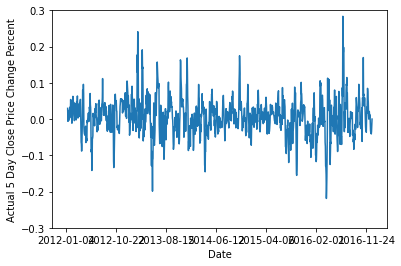

In [41]:
y_series = pd.Series(stock_data['5d_close_future_pct'], index = stock_data.index)
y_series.plot()
plt.ylabel("Actual 5 Day Close Price Change Percent")
plt.ylim(-0.3, 0.3)
plt.show()

In [42]:
stock_data.dropna(inplace=True)

X = stock_data[feature_names]
y = stock_data['5d_close_future_pct']

train_size = int(0.85 * y.shape[0])
X_train = X[:train_size]
y_train = y[:train_size]
X_test = X[train_size:]
y_test = y[train_size:]

In [23]:
grid = {'n_estimators': np.arange(100, 900, 200), 
        'max_depth': np.arange(1, 15, 1), 
        'max_features': [4, 8], 
        'random_state': [42],
        'oob_score' : [True],
        'bootstrap' : [True]}
test_scores = []

rf_model = RandomForestRegressor()

for g in ParameterGrid(grid):
    rf_model.set_params(**g) 
    rf_model.fit(X_train, y_train)
    test_scores.append(rf_model.oob_score)

best_index = np.argmax(test_scores)
print(test_scores[best_index], ParameterGrid(grid)[best_index])

KeyboardInterrupt: 

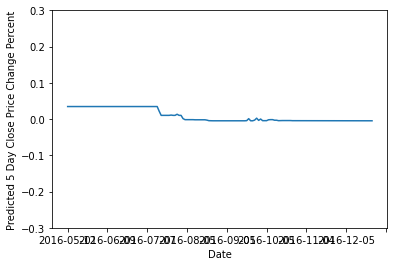

In [43]:
rf_model = RandomForestRegressor(random_state = 42, n_estimators = 100, max_features = 4, max_depth = 1, bootstrap = True)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

y_pred_series = pd.Series(y_pred, index=y_test.index)
y_pred_series.plot()
plt.ylabel("Predicted 5 Day Close Price Change Percent")
plt.ylim(-0.3, 0.3)
plt.show()

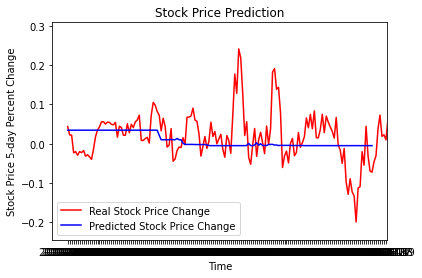

In [48]:
plt.plot(stock_data['5d_close_future_pct'], color = 'red', label = 'Real Stock Price Change')
plt.plot(y_pred, color = 'blue', label = 'Predicted Stock Price Change')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price 5-day Percent Change')
plt.xlim(-7.65, 160.65)
plt.legend()
plt.show()

In [45]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 0.04540078144828159
Mean Squared Error: 0.003622193027760393
Root Mean Squared Error: 0.06018465774398317


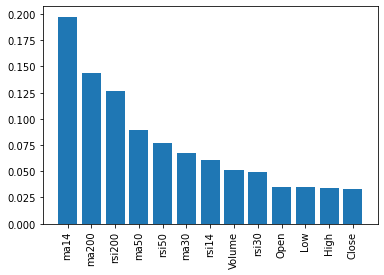

In [27]:
importances = rf_model.feature_importances_
sorted_index = np.argsort(importances)[::-1]
x_values = range(len(importances))
labels = np.array(feature_names)[sorted_index]
plt.bar(x_values, importances[sorted_index], tick_label=labels)
plt.xticks(rotation=90)
plt.show()

**NO GRID SEARCH**

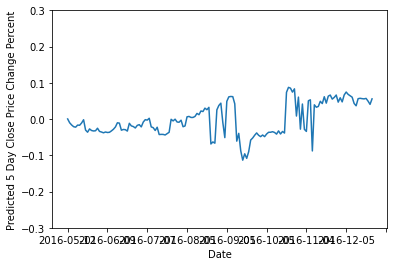

In [28]:
rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

y_pred_series = pd.Series(y_pred, index=y_test.index)
y_pred_series.plot()
plt.ylabel("Predicted 5 Day Close Price Change Percent")
plt.ylim(-0.3, 0.3)
plt.show()

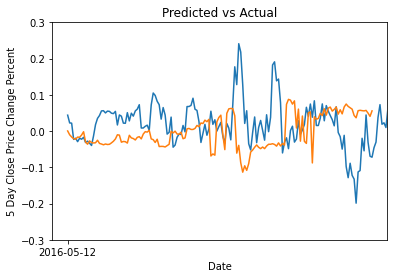

In [30]:
y_series.plot()
y_pred_series.plot()
plt.title("Predicted vs Actual")
plt.ylabel("5 Day Close Price Change Percent")
plt.ylim(-0.3, 0.3)
plt.xlim(-7.65, 160.65)
plt.show()

In [16]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 0.05630518935217239
Mean Squared Error: 0.005486942300549031
Root Mean Squared Error: 0.0740738975655327


**Linear Regression**

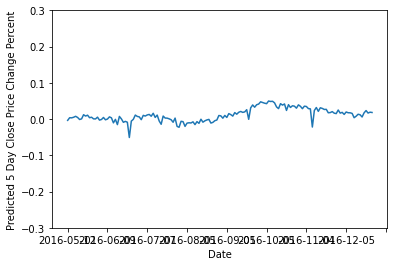

In [17]:
model = LinearRegression()
model.fit(X_train, y_train)

pred = model.predict(X_test)

y_pred_series = pd.Series(pred, index=y_test.index)
y_pred_series.plot()
plt.ylabel("Predicted 5 Day Close Price Change Percent")
plt.ylim(-0.3, 0.3)
plt.show()

In [18]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, pred)))

Mean Absolute Error: 0.04256359546802597
Mean Squared Error: 0.0036955711366539134
Root Mean Squared Error: 0.060791209369890915
